<a href="https://colab.research.google.com/github/harmanpreet93/reinforcement-learning-COMP-767/blob/master/BairdCounterExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Baird Counter Example

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class BairdMDP():
    
    def __init__(self):
        self.SOLID = 1
        self.DASH = 0
        self.NUM_OF_STATES = 7
        self.step_prob = 1/self.NUM_OF_STATES
    
    def pick_action(self):
        action = np.random.binomial(1, self.step_prob)
        return action

    def step(self, action):
        if action == self.SOLID:
            next_state = 6
        elif action == self.DASH:
            next_state = np.random.choice(self.NUM_OF_STATES - 1)
        return next_state

In [0]:
class SemiGradientTD0():

    def __init__(self, bairdMDP, gamma=0.99, alpha=0.01):
        self.mdp = bairdMDP
        self.gamma = gamma
        self.alpha = alpha
        self.initialize_features_and_weights()

    def initialize_features_and_weights(self):
        self.weights = self.initialize_weights()
        self.features = self.get_feature_representation()

    def initialize_weights(self):
        return np.array([1,1,1,1,1,1,10,1], dtype=np.float32)

    def get_feature_representation(self):
        return np.array([[2, 0, 0, 0, 0, 0, 0, 1],
                        [0, 2, 0, 0, 0, 0, 0, 1],
                        [0, 0, 2, 0, 0, 0, 0, 1],
                        [0, 0, 0, 2, 0, 0, 0, 1],
                        [0, 0, 0, 0, 2, 0, 0, 1],
                        [0, 0, 0, 0, 0, 2, 0, 1],
                        [0, 0, 0, 0, 0, 0, 1, 2]], dtype=np.float32)
        
    def value(self, state):
        return np.dot(self.weights, self.features[state])

    def run_TD_algorithm(self, n_steps=1000):
        current_state = np.random.choice(mdp.NUM_OF_STATES)
        step_weights = np.zeros((n_steps, len(self.weights)))
        values = np.zeros((n_steps)) 
        step = 0
        while step < n_steps:
            step_weights[step] = self.weights
            values[step] = self.value(current_state)
            action = self.mdp.pick_action()
            next_state = self.mdp.step(action)
            if action == self.mdp.DASH:
                rho = 0
            else:
                rho = 1/self.mdp.step_prob
            delta = self.gamma * self.value(next_state) - self.value(current_state)
            self.weights += self.alpha * rho * delta * self.features[current_state]
            current_state = next_state
            step += 1

        return step_weights, values


def plot_weights_graph(step_weights):
    plt.figure(figsize=[7,7.5])
    steps, num_weights = step_weights.shape
    for i in range(num_weights):
        plt.plot(range(steps), step_weights[:,i], label="w{}".format(i+1))
    plt.xlabel("Steps")
    plt.title("Semi-gradient Off-policy TD(0)")
    plt.legend();

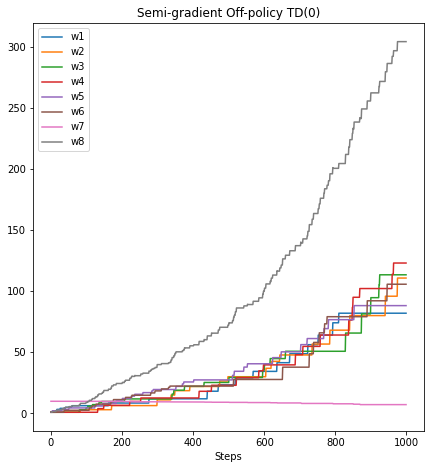

In [190]:
mdp = BairdMDP()
semiGradTD = SemiGradientTD0(mdp)
step_weights, values = semiGradTD.run_TD_algorithm(n_steps=1000)
plot_weights_graph(step_weights)